![MLU Logo](../MLU_Logo.png)

# Assignment 5

This class, aside from a discussion of alternative optimizer choices, was primarily focused on learning about the notion of weight sharing, and motivating content that will be learned further down the line in DL2.  As such, we will focus this entire assignment on the final project, and leave the week fully open for you to continue to refine your model.

## Related Readings
* [Chapter 11](http://d2l.ai/chapter_optimization/index.html) discusses different choices of optimizer that can be made.
* [Chapter 6](http://d2l.ai/chapter_convolutional-neural-networks/index.html) and [Chapter 8](http://d2l.ai/chapter_recurrent-neural-networks/index.html) discusses convolutions and recurrent neural networks.  Nothing past section 1 of these chapters is related to this class, however it is a good section to read to prepare yourself for DL2.

In [3]:
!pip install -r ../requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 76 kB 3.9 MB/s            
     |████████████████████████████████| 14.8 MB 31.9 MB/s            
     |████████████████████████████████| 763.6 MB 12 kB/s               
     |████████████████████████████████| 17.3 MB 101.0 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


In [4]:
# Import sklearn datasets and train_test_split
from sklearn.model_selection import train_test_split

# Import plotting libraries
import matplotlib.pyplot as plt

# Import Pytorch
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torch.utils import data
from torchvision import transforms

# Import helper libraries
import pandas as pd
import boto3
import pickle

from itertools import product
import random

import numpy as np

## Final Project Data

Below I again load in the data, and provide the code to prepare the predictions for Leaderboard.

### IMPORTANT
You will need to change the __buckename__ variable below:

   1. Go to the S3 console 
   2. Look for the bucket named with the prefix __labstack-__ where you have downloaded your data files form the course portal
   3. Change the code below using the bucket name

In [5]:
# import the datasets
bucketname = 'labstack-0fdc222c-e087-4b8f-8829-a8cf82-labbucket-1hgzg5on2m9ch' # replace with your bucket name

import pickle
import boto3

s3 = boto3.resource('s3')
#my_pickle = pickle.loads(s3.Bucket("labstack-0fdc222c-e087-4b8f-8829-a8cf82-labbucket-1hgzg5on2m9ch").Object("data/DL1_Train.pkl").get()['Body'].read())

final_train = pickle.loads(s3.Bucket("labstack-0fdc222c-e087-4b8f-8829-a8cf82-labbucket-1hgzg5on2m9ch").Object("data/DL1_Train.pkl").get()['Body'].read(), encoding="latin1")
final_test = pickle.loads(s3.Bucket("labstack-0fdc222c-e087-4b8f-8829-a8cf82-labbucket-1hgzg5on2m9ch").Object("data/DL1_Test.pkl").get()['Body'].read(), encoding="latin1")

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
# final_train = pickle.load(open("../data/DL1_Train.pkl", "rb"), encoding="latin1")
# final_test = pickle.load(open("../data/DL1_Test.pkl", "rb"), encoding="latin1")

td = {
    "DRUM & BASS": 0,
    "R&B": 1,
    "BLUES": 2,
    "VOCAL JAZZ": 3,
    "NATURE SOUNDS": 4,
    "BAROQUE": 5,
    "DISNEY": 6,
    "HARD ROCK": 7,
}

full = [
    (final_train[key]["PACH"], td[final_train[key]["text_genre"][0]])
    for key in final_train.keys()
    if len(final_train[key]["text_genre"]) == 1
]



train, val = train_test_split(full, random_state=8675309)#, test_size=0.1


In [7]:
final_full_loader = data.DataLoader(full, batch_size=100, shuffle=True)
final_train_loader = data.DataLoader(train, batch_size=100, shuffle=True)
final_val_loader = data.DataLoader(val, batch_size=100, shuffle=True)
final_test_iter = data.DataLoader(
    final_test["test_data"], batch_size=100, shuffle=False
)

## Build your custom net below


In [8]:
# func: evaluate test/val data
def evaluate_loss_gpu(net, data_iter, device="cuda:0" if torch.cuda.is_available() else "cpu"): #@save
    loss = nn.CrossEntropyLoss()
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        l = loss(net(X), y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [11]:
def he_init(m, magnitude=2):
    """Initialize weights with He initialization (https://arxiv.org/pdf/1502.01852.pdf)"""
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(magnitude) / m.shape[1])
        return m.data.normal_(0, scale)


def init_weights(m, magnitude=2):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        he_init(m.weight, magnitude)

In [12]:
from torch.optim.lr_scheduler import MultiStepLR

def train_final(net, train_iter, test_iter, num_epochs=80,  lr=0.005, magnitude=4, weight_decay=0, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    
    
    net.apply(lambda m: init_weights(m, magnitude=magnitude))
    print('training on', device)
    
    #net.apply(lambda m: init_weights(m, magnitude=magnitude))
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(),  lr=lr, weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    
    scheduler = MultiStepLR(optimizer, milestones=[10,30,50,70,90], gamma=0.5)
    
    test_losses = []
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['val acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        net.train()
        for i, (X, y) in enumerate(final_train_loader):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l.sum(),  X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[1]
        test_acc = evaluate_accuracy_gpu(net, final_val_loader)
        animator.add(epoch+1, (test_acc))
    print('validation acc %.3f' % (test_acc))
    print('%.1f examples/sec on %s' % (metric[1]*num_epochs/timer.sum(), device))

validation acc 0.891
38665.3 examples/sec on cuda:0


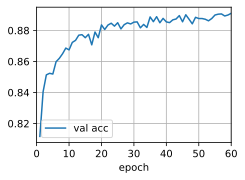

In [13]:
%time

mid_l1 = 512
mid_l2 = 256

net=nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(4096,mid_l1),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(mid_l1, mid_l2),
    nn.ReLU(),
    nn.BatchNorm1d(mid_l2),
    nn.Dropout(0.5),
    nn.Linear(mid_l2,8)
    )

#train_net(final_train_loader, final_val_loader, num_layers=1, num_epochs=80, plot_acc=False)
train_final(net, final_train_loader, final_val_loader, num_epochs=60,  lr=0.001, magnitude=2, weight_decay=0)

In [14]:
# func: train_model
def train_net(train_iter, test_iter, 
              num_layers = 2, 
              num_epochs = 20, lr = 0.001, dr= 0.5, init_magnitude=2, 
              seed=8675309, 
              device=d2l.try_gpu(), 
              plot_acc=True, plot_loss=False, verbose=True):
    # setup random seed
    torch.manual_seed(seed)
    # create the net
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Dropout(.2))
    layers.append(nn.Linear(4096, 1024))
    layers.append(nn.ReLU())
    layers.append(nn.BatchNorm1d(1024))
    layers.append(nn.Dropout(dr))
    
    if num_layers > 1:
        for l in range(num_layers - 1):
            layers.append(nn.Linear(1024, 1024))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(1024))
            layers.append(nn.Dropout(dr))
            
    layers.append(nn.Linear(1024, 8))
    net = nn.Sequential(*layers)
    
    # init weight
    def he_init(m, magnitude):
        scale = torch.sqrt(torch.tensor(magnitude) / m.shape[1])
        return m.data.normal_(0, scale)
    
    def init_weights(m, magnitude):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            he_init(m.weight, magnitude)       
    net.apply(lambda m: init_weights(m, init_magnitude))
    
    if verbose:
        print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    test_losses = []
    if plot_acc:
        animator_acc = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                                    legend=['val acc'])
    if plot_loss:
        animator_loss = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                                     legend=['val loss'])
    timer = d2l.Timer()
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        net.train()
        for i, (X, y) in enumerate(final_train_loader):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l.sum(),  X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[1]
        test_acc = evaluate_accuracy_gpu(net, final_val_loader)
        if plot_acc:
            animator_acc.add(epoch+1, (test_acc))
        
        test_loss = evaluate_loss_gpu(net, final_val_loader)
        if plot_loss:
            animator_loss.add(epoch+1, (test_loss))
    
    if verbose:
        print('validation acc %.3f' % (test_acc))
        print('validation loss %.3f' % (test_loss))
        print('%.1f examples/sec on %s' % (metric[1]*num_epochs/timer.sum(), device))
    return net, test_acc, test_loss



validation acc 0.888
validation loss 0.457
24668.4 examples/sec on cuda:0
CPU times: user 3min 2s, sys: 15.1 s, total: 3min 17s
Wall time: 3min 16s


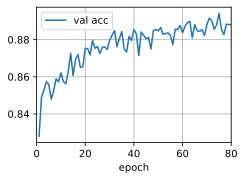

In [19]:
%%time
# test train
_, _, _ = train_net(final_train_loader, 
                    #final_full_loader,
                    final_val_loader, 
                    num_layers=2, num_epochs=80, lr=0.01,dr=0.5,init_magnitude=4
#                     num_layers=2, 
#                     num_epochs=60,
#                     lr=0.0005,
#                     dr=0.5,
#                     init_magnitude=4,
                    #plot_acc=False,plot_loss=False,verbose=False
                   )

validation acc 0.888
validation loss 0.457
24499.4 examples/sec on cuda:0


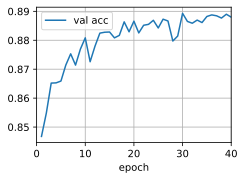

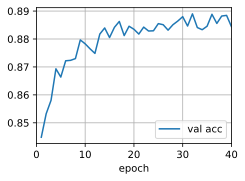

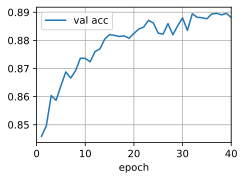

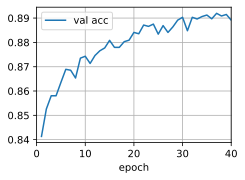

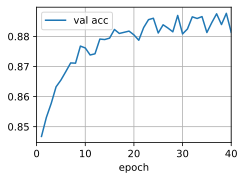

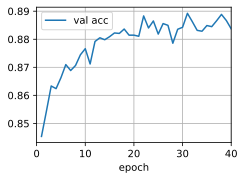

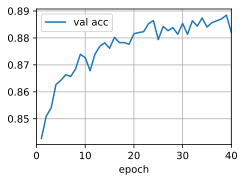

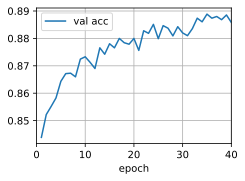

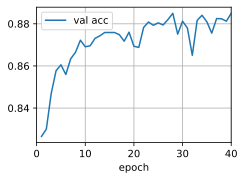

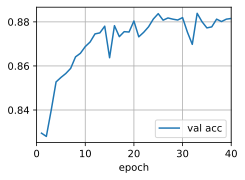

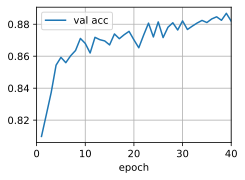

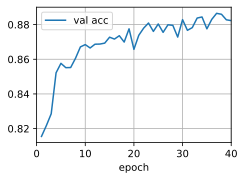

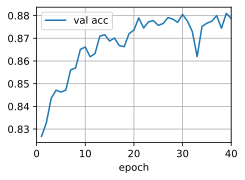

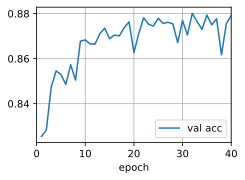

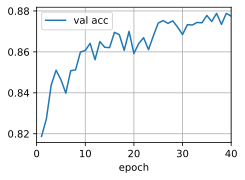

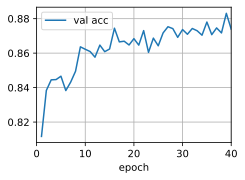

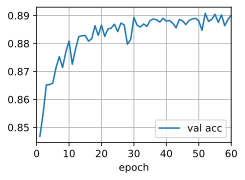

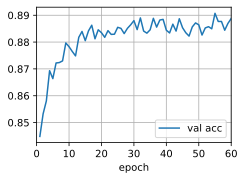

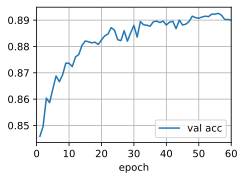

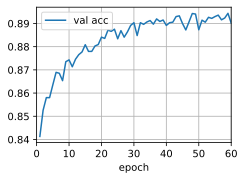

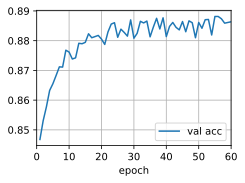

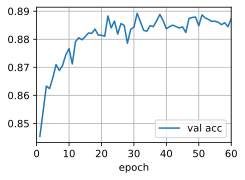

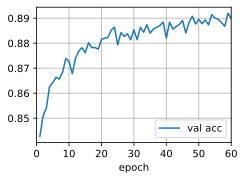

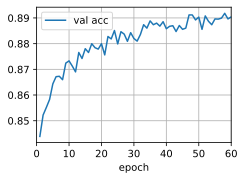

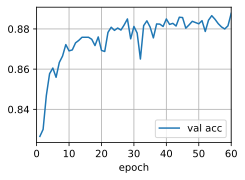

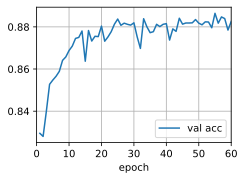

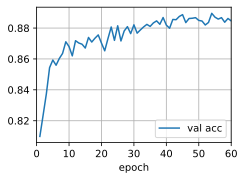

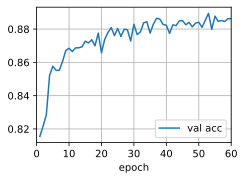

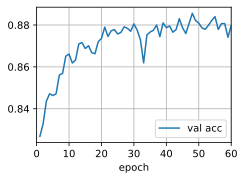

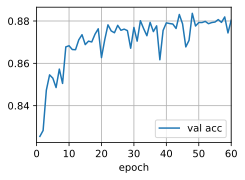

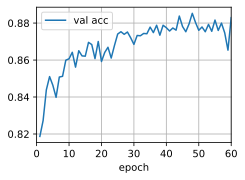

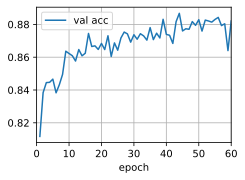

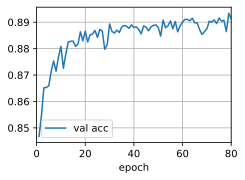

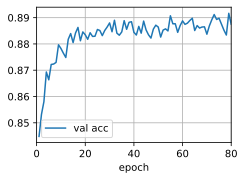

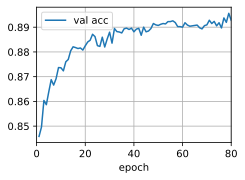

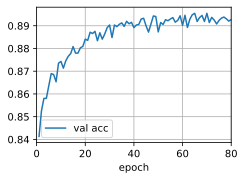

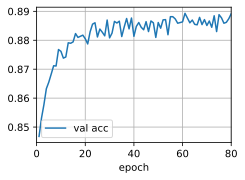

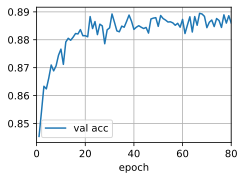

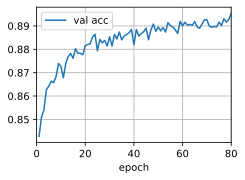

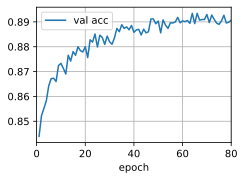

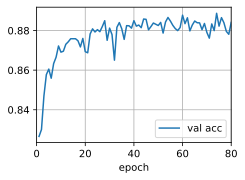

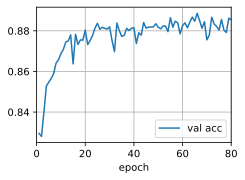

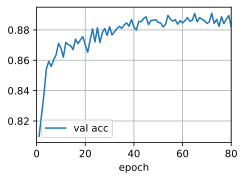

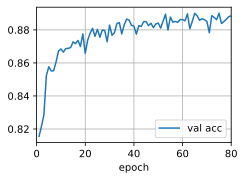

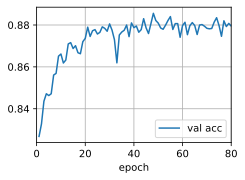

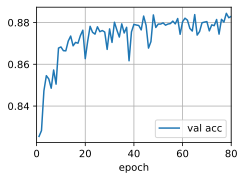

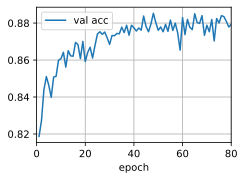

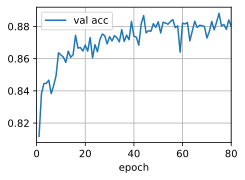

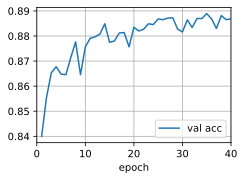

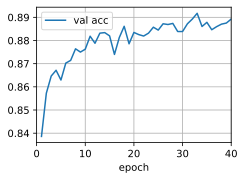

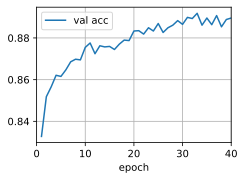

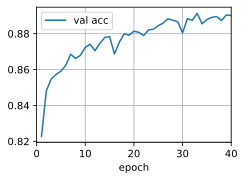

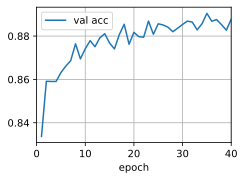

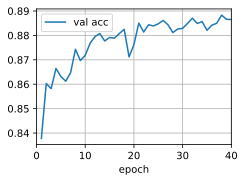

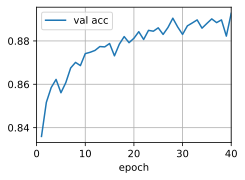

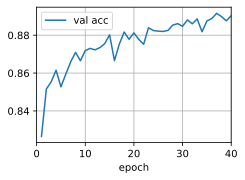

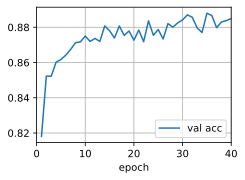

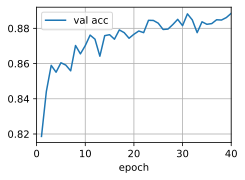

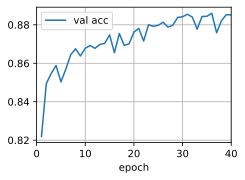

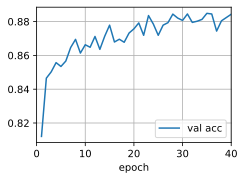

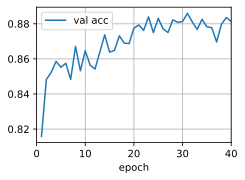

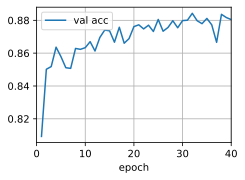

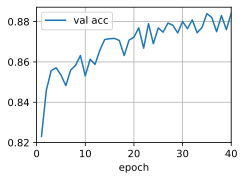

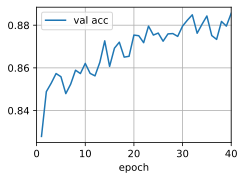

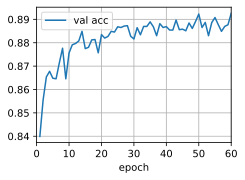

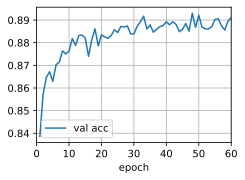

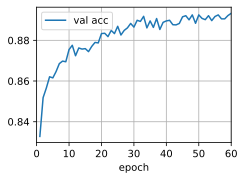

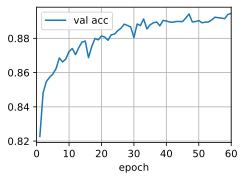

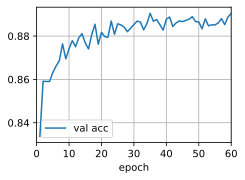

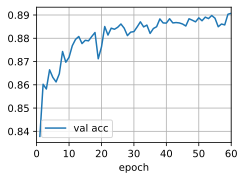

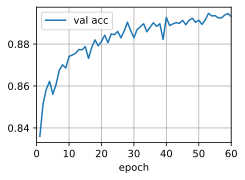

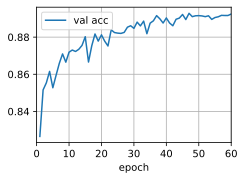

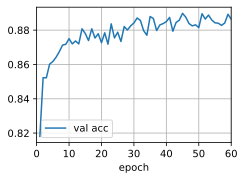

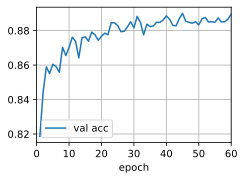

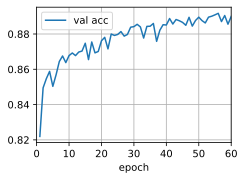

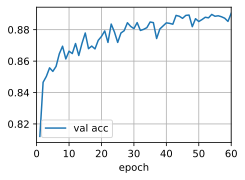

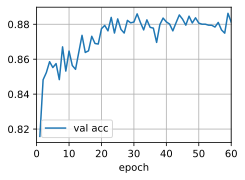

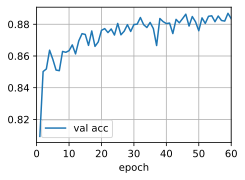

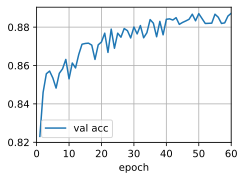

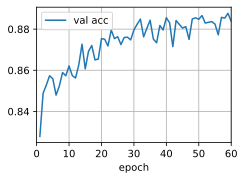

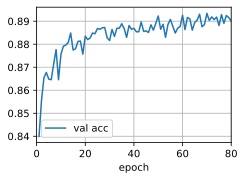

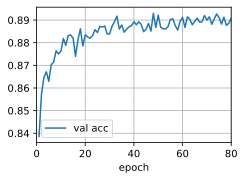

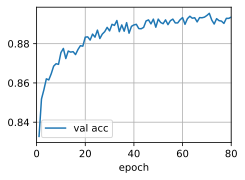

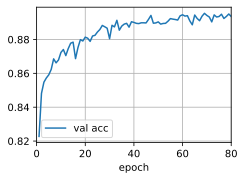

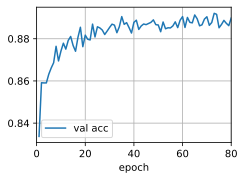

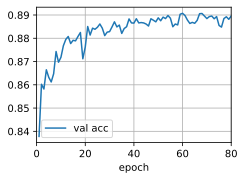

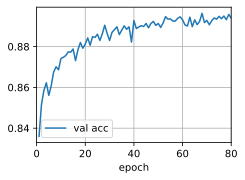

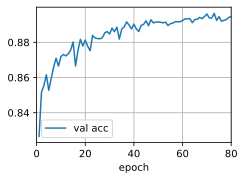

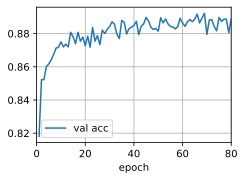

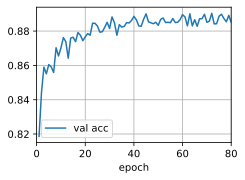

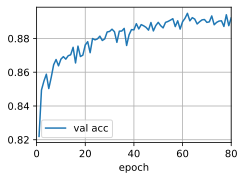

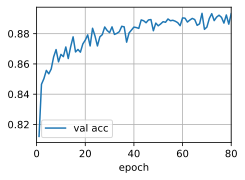

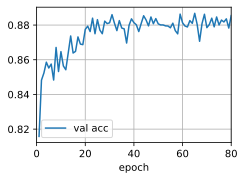

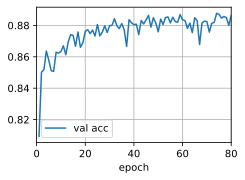

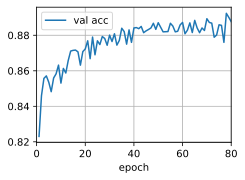

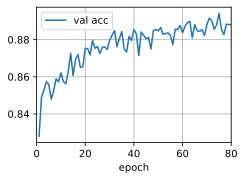

In [ ]:
%time

# tune hyper parameters
list_layers=[1, 2]
list_epochs=[40, 60, 80]
list_lr = [.0005, 0.001, 0.005, 0.01]
list_dr = [0.2, 0.5]
list_magnitude=[2, 4]

n = len(list(product(list_layers, list_epochs, list_lr, list_dr, list_magnitude)))
print(f'Total combinations to search: {n}')

res = []

for l, epoch, lr, dr, m in product(list_layers, list_epochs, list_lr, list_dr, list_magnitude):
    _, test_acc, test_loss = train_net(
        final_train_loader, 
        final_val_loader, 
        num_layers=l, 
        num_epochs=epoch,
        lr=lr,
        dr=dr,
        init_magnitude=m,
#         plot_acc=False,
#         plot_loss=False,
#         verbose=False
    )
    res.append((l, epoch, lr, dr, m, test_acc, test_loss))

df_tune = pd.DataFrame(res, columns=['layer', 'epoch', 'lr', 'dropout', 'magnitude', 'test_accuracy', 'test_loss'])
df_tune.to_csv('tune_results.csv', index=False)


In [ ]:
df_tune

,layer,epoch,lr,dropout,magnitude,test_accuracy,test_loss
0,1,40,0.0005,0.2,2,0.887990,0.469329
1,1,40,0.0005,0.2,4,0.884412,0.470414
2,1,40,0.0005,0.5,2,0.888146,0.392991
3,1,40,0.0005,0.5,4,0.889157,0.389647
4,1,40,0.0010,0.2,2,0.881378,0.512063
...,...,...,...,...,...,...,...
91,2,80,0.0050,0.5,4,0.893202,0.411162
92,2,80,0.0100,0.2,2,0.885423,253.467320
93,2,80,0.0100,0.2,4,0.886201,4.651992
94,2,80,0.0100,0.5,2,0.887679,0.473554


In [57]:
print("num_layers", l)
print("num_epochs", epoch)
print("lr", lr)
print("dr", dr)
print("init_magnitude", m)

num_layers 2
num_epochs 80
lr 0.01
dr 0.5
init_magnitude 4


In [16]:
def predict(seed=8675309):
    net, _, _ = train_net(
        final_train_loader, 
        final_val_loader, 
        num_layers=2, num_epochs=80, lr=0.01,dr=0.5,init_magnitude=4,
#         num_layers=l, 
#         num_epochs=epoch,
#         lr=lr,
#         dr=dr,
#         init_magnitude=m,
        seed = seed,
        plot_acc=False,
        plot_loss=False,
        verbose=False
    )
    
    final_X = np.array(final_test["test_data"])
    final_X = torch.from_numpy(final_X).to(d2l.try_gpu())

    preds = torch.argmax(net(final_X), axis=1).type(torch.long)

    # Make the predictions in the format needed by leaderboard
    genre_list = [
        "DRUM & BASS",
        "R&B",
        "BLUES",
        "VOCAL JAZZ",
        "NATURE SOUNDS",
        "BAROQUE",
        "DISNEY",
        "HARD ROCK",
    ]
    predictions = [genre_list[p] for p in preds.tolist()]
    df_out = pd.DataFrame()
    df_out["ID"] = final_test["test_labels"]
    df_out[f"genre_{seed}"] = predictions
    return df_out

In [ ]:
# get a list of random seed

# list_seed = []
# for i in range(25):
#     list_seed.append(random.randint(1, 10000000))

%time

list_seed = [2934723, 2342353, 45390580, 989798, 378756, 
             976, 90387, 900846, 237646, 938765, 
             2, 34345, 235466, 32534564, 2353425, 
             9389, 876875, 98651, 34657,57575, 
             65868, 8675309, 7113132, 8390124, 248360]

df_out = pd.DataFrame()
for seed in list_seed:
    df_temp = predict(seed)
    if df_out.empty:
        df_out = df_temp.copy()
    else:
        df_out = df_out.append(df_temp)


# df_out['genre'] = df_out.mode(axis=1).iloc[:, 0]

# df_out = df_out.filter(['ID', 'genre'])


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [17]:
df_out.shape

(333650, 26)

In [40]:
df_out.tail()

,ID,genre_2934723,genre_2342353,genre_45390580,genre_989798,genre_378756,genre_976,genre_90387,genre_900846,genre_237646,...,genre_9389,genre_876875,genre_98651,genre_34657,genre_57575,genre_65868,genre_8675309,genre_7113132,genre_8390124,genre_248360
13341,B00A138IJG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOCAL JAZZ
13342,B00B2OH9OS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOCAL JAZZ
13343,B00S2ARDK0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R&B
13344,B01LZNAY65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R&B
13345,B01MTOX2OU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HARD ROCK


In [19]:
df_out_copy = df_out

In [41]:
df_out['genre'] = df_out.mode(axis=1).iloc[:, 1:]

In [45]:
df_out_only = df_out[['ID','genre']]

In [49]:
df_out_groupby = df_out_only.groupby(['ID'])['genre'].agg(pd.Series.mode).to_frame()

In [51]:
df_out_groupby['ID'] = df_out_groupby.index
df_out_groupby

,genre,ID
ID,,
B000Q3FQEQ,BAROQUE,B000Q3FQEQ
B000Q3HQLC,BAROQUE,B000Q3HQLC
B000Q3ICR4,BAROQUE,B000Q3ICR4
B000Q3J98K,BAROQUE,B000Q3J98K
B000Q3J9K8,BAROQUE,B000Q3J9K8
...,...,...
B072MGFHVP,R&B,B072MGFHVP
B072MGFWVH,R&B,B072MGFWVH
B072P1H6P1,R&B,B072P1H6P1


In [ ]:
df_out_groupby.to_csv("./FFNN_submission_Bin.csv", index=False)


In [ ]:

#df_out.to_csv('df_out_ensemble.csv', index=False)


In [31]:
df_out_copy = df_out

df_output = df_out.mode(axis='columns', dropna=True)
df_output.rename(columns={ df_output.columns[0]: "ID", df_output.columns[1]:"genre" }, inplace=True)
df_output.head()

,ID,genre
0,B002FTAB1M,HARD ROCK
1,B01C3HNC1Q,VOCAL JAZZ
2,B005I89EQA,BAROQUE
3,B004DD1LX0,R&B
4,B00KZB91KE,HARD ROCK


In [32]:
df_output.shape

(13346, 2)

In [53]:
df_out_groupby.to_csv("./FFNN_submission_Bin.csv", index=False)


## Submit to Leaderboard

In [ ]:
# final_X = np.array(final_test["test_data"])
# final_X = torch.from_numpy(final_X).to(d2l.try_gpu())

# preds = torch.argmax(net(final_X), axis=1).type(torch.long)

# # Make the predictions in the format needed by leaderboard
# genre_list = [
#     "DRUM & BASS",
#     "R&B",
#     "BLUES",
#     "VOCAL JAZZ",
#     "NATURE SOUNDS",
#     "BAROQUE",
#     "DISNEY",
#     "HARD ROCK",
# ]
# predictions = [genre_list[p] for p in preds.tolist()]
# df_out = pd.DataFrame()
# df_out["ID"] = final_test["test_labels"]
# df_out["genre"] = predictions

In [ ]:
df_out.to_csv("./FFNN_submission.csv", index=False)